# Module 2: Water flow in soil

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

In [1]:
# We first import libraries and define some auxiliary functions:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

In [2]:
# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

In [3]:
# Computation of analytical solution
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)
#
jwpot_ = [-0.1, -0.1, -0.3, -0.3] # potential eflux (cm/day)
head_i_ = [-40, -200, -200, -200] # initial soil matric potential (cm)

N = 1000
y = np.zeros((N,4))
t = np.linspace(0,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):  
    
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]      
    
    dw = lambda TH: water_diffusivity(TH,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    
  
    theta_dw = lambda TH: TH*water_diffusivity(TH,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # Eqn 43

    fun_dw = lambda TH: pow(1-TH*beta,2)*dw(TH)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw  # Eqn 42

    mu = ( 3*beta*(1+sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # Eqb 41
    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*sqrt((4/mu)*int_dw) # Eqn 39  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # Eqn 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # Eqn 45
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

t4 = t # remember results for later
y4 = abs(y)

## Comparison of numerical solutions to reference solution

There are many softwares solving Richards equation. Benchmark M2.2 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. (2005). With this Jupyter Notebook, we enable automated comparison of the results of additional numerical codes. The easiest way to contribute is to implement this benchmark problem and provide the results to be stored on the specified folder in the github repository.  

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available:

* [Dumux](Soil water flow - Dumux.ipynb)

### Benchmark M2.2

For an automatic comparison of the numerical results, save the results in a text file with two rows containing comma separated time points [day] in the first, and actual evaporation rate [cm day-1] in the second. This is done for each scenario, with low and high resolution (i.e. 4 (scenarios) * 2 (resolutions) results = 16 rows). Copy the file to the folder /M2.2 Numerical results/.

R² = -1.5551598898878063 ( N = 1447 )

R² = 0.8850883109801855 ( N = 1447 )

R² = 0.724399629354137 ( N = 1447 )

R² = 0.9449481507943871 ( N = 1447 )

R² = -0.27145048759980583 ( N = 101 )

R² = 0.9641740909621154 ( N = 1002 )

R² = 0.9220351128135108 ( N = 201 )

R² = 0.9771090071102275 ( N = 602 )

R² = -3.946406373437357 ( N = 130 )

R² = 0.899756145112291 ( N = 120 )

R² = 0.8198050234274095 ( N = 284 )

R² = 0.9438633542534786 ( N = 149 )



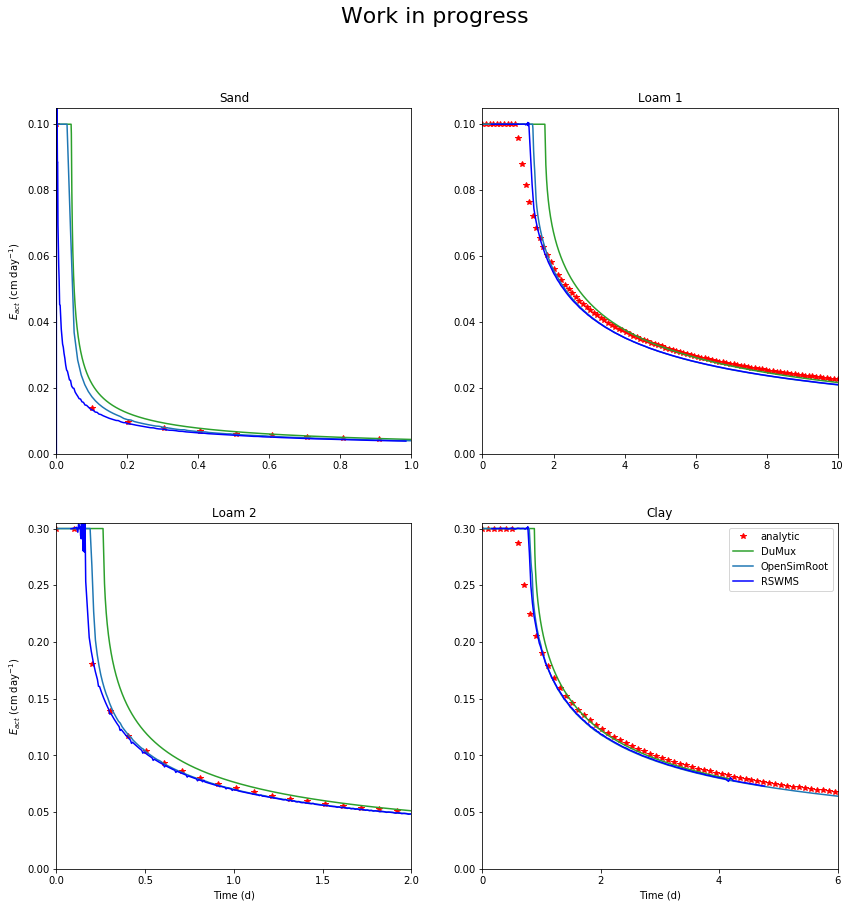

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))  
l=['analytic']
for j in range(0,4):   
    t_ = np.linspace(0,10,100)
    interp = interp1d(t4, y4[:,j],  kind='linear', fill_value='extrapolate' ) 
    ax[int(j/2),j%2].plot(t_,interp(t_),'r*', label="analytic")  

col=["C2","C0","b"]
for dirname, dirnames, filenames in os.walk('M2.2 Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):        
        try:              
            data = []
            with open('M2.2 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")  
                    data.append(s) 
                         
            for j in range(0,8): # 0-3 low res, 4-7 high res                
                t = data[2*j] 
                eva = data[2*j+1]                   
                j_ = j % 4 # scenario index (i.e. 0-3)                           
                interp = interp1d(t4, y4[:,j_],  kind='linear', fill_value='extrapolate' ) 
                eva_a = interp(sorted(t))
                if j>3: # R² values for higher discretizations                    
                    n = len(eva) # calculate R^2
                    r = 1 - ( np.sum(np.square(eva_a-eva)) / (np.sum(np.square(eva_a))-np.square(np.sum(eva_a))/n) )    
                    print("R² =", r ,"( N =", n, ")\n")                
                    ax[int(j_/2),j_%2].plot(t,eva,color=col[i], label=f) # numeric solution 
                #else:
                    #ax[int(j_/2),j_%2].plot(t,eva,':',color=col[i], label=f+" lr" )# numeric solution   
                    
                if j_>1:
                    ax[int(j_/2),j_%2].set_xlabel("Time (d)")
                if j == 0 or j == 2:
                    ax[int(j_/2),j_%2].set_ylabel('$E_{act}$ (cm day$^{-1}$)')                       
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)
            
ax[0,0].set_ylim(0,0.105) 
ax[0,1].set_ylim(0,0.105) 
ax[1,0].set_ylim(0,0.305) 
ax[1,1].set_ylim(0,0.305) 
ax[0,0].set_xlim(0,1) 
ax[0,1].set_xlim(0,10) 
ax[1,0].set_xlim(0,2) 
ax[1,1].set_xlim(0,6) 
ax[0,0].set_title('Sand');ax[0,1].set_title('Loam 1');ax[1,0].set_title('Loam 2');ax[1,1].set_title('Clay');
plt.legend()
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
fig.suptitle("Work in progress")
#plt.savefig('m22_results.png', dpi=300, bbox_inches = "tight")
plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221